# Solution

## Research Question 1

**Text**\
What are the most frequently mentioned words on Nextdoor? 

In [1]:
#main dependencies

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import spacy

In [2]:
#import merged dataset
df = pd.read_csv(r"https://raw.githubusercontent.com/Learning-CCS-by-JY/SMCA/main/Dataset/merge%20data.csv", usecols=range(2,18)) #use only columns from 2 to 18
df.head(5) #print first 5 rows of the df

,ID,Text,Comment Count,Post Author,Neighbourhood,Date,Reaction Count,Comment,Comment Author,Comment Author Neighbourhood,Comment ID,WOZ,Owner-occupied property,Rental property,Income_pir,Income_pr
0,s_17592213863608,Deze week komt de Amsterdam krant uit en wij s...,0,Lotty Liefting,Indische Buurt Zuid West,27/12/2022,3,NaN,NaN,NaN,NaN,351.0,18.0,82.0,27.3,22.2
1,s_17592214199382,Hello neighbours! \n\nCurrently I'm following ...,15,Chris M.,Czaar Peter,11/01/2023,9,"Hoi Chris,\nGeïnteresseerd \nGroetjes Marein",Marein,KNSM-Eiland,comment_17592255145484,349.0,22.0,78.0,37.2,32.0
2,s_17592214199382,Hello neighbours! \n\nCurrently I'm following ...,15,Chris M.,Czaar Peter,11/01/2023,9,Hierboven is mijn emailadres,Marein,KNSM-Eiland,comment_17592255145503,349.0,22.0,78.0,37.2,32.0
3,s_17592214199382,Hello neighbours! \n\nCurrently I'm following ...,15,Chris M.,Czaar Peter,11/01/2023,9,"hi chris, i would be happy to help - in conjun...",Kayce Maisel,Indische Buurt West,comment_17592255148328,349.0,22.0,78.0,37.2,32.0
4,s_17592214199382,Hello neighbours! \n\nCurrently I'm following ...,15,Chris M.,Czaar Peter,11/01/2023,9,Als je ook ouder hoofd nodig hebt...,Hanneke Stasse,Kadijken,comment_17592255158481,349.0,22.0,78.0,37.2,32.0


## Model loading and pre-processing

In [3]:
#spacy models
'''
Please make sure you have downloaded the two models using the following method in the Terminal

python -m spacy download en_core_web_sm
python -m spacy download nl_core_news_sm
'''
import en_core_web_sm #import English model
import nl_core_news_sm #import Dutch model

english_model = en_core_web_sm.load() #assign english model
dutch_model = nl_core_news_sm.load() #assign dutch model

In [4]:
#Subset by comments (drop duplicates in the comment column)
df = df.drop_duplicates(subset = ["Comment"])
df = df.dropna(subset = ["Comment"])
df = df.reset_index(drop=True)

#language detection for df grouping (here I only detect comment language)
import langdetect

langs = [] #create language list

for row in range(len(df)):
    try:
        lang = langdetect.detect(str(df['Comment'][row])) #detect language
        print(f"language of row {row} is {lang}")
            
    except:
        language = "error"
        print(f"Error occured in row {row}")

        lang = "nil"
    
    langs.append(lang)

df['lang'] = langs #assign language list to df

df['lang'] = df['lang'].where(df['lang'].isin(['nl', 'en','nil']), 'nl') #assign nl to non-en and non-nl texts (checked)

#grouping
df_nl = df.loc[df['lang'] == 'nl']
df_en = df.loc[df['lang'] == 'en']

#reset index
df_nl = df_nl.reset_index(drop=True)
df_en = df_en.reset_index(drop=True)

language of row 0 is nl
language of row 1 is nl
language of row 2 is en
language of row 3 is af
language of row 4 is nl
language of row 5 is nl
language of row 6 is nl
language of row 7 is nl
language of row 8 is nl
language of row 9 is nl
language of row 10 is sl
language of row 11 is tr
language of row 12 is nl
language of row 13 is nl
language of row 14 is nl
language of row 15 is nl
language of row 16 is nl
language of row 17 is de
language of row 18 is nl
language of row 19 is af
language of row 20 is nl
language of row 21 is nl
language of row 22 is nl
language of row 23 is sw
language of row 24 is nl
language of row 25 is nl
language of row 26 is nl
language of row 27 is nl
language of row 28 is nl
language of row 29 is nl
language of row 30 is nl
language of row 31 is nl
language of row 32 is nl
language of row 33 is nl
language of row 34 is nl
language of row 35 is nl
language of row 36 is nl
language of row 37 is nl
language of row 38 is nl
language of row 39 is nl
language o

In [5]:
'''
Here we do a few pre-processing for the Dutch text:
1. tokenization
2. remove punctuation, stopwords, currencies, url, email, numbers and non-ALPHA characters
3. lemmatisation 
'''
import re
def cleaning(text):
    doc = dutch_model(text)

    #tokenize and remove punct, stopwords, currencies (e.g., $), url, email and numbers
    tokenized = [token.text for token in doc if not token.is_punct and not token.is_stop and not token.is_currency and not token.like_num and not
    token.like_url and not token.like_email]

    #joining tokenized text
    tokenized_text = " ".join(tokenized)

    #remove weird characters
    tokenized_text = re.sub(r"[^a-zA-Z']", " ", tokenized_text) #remove anything other than alpha
    tokenized_text = re.sub(r"\s+", " ", tokenized_text) #replace >1 spaces (\s+) with only one space

    #to lower
    tokenized_text = tokenized_text.lower()

    #lemmatise
    clean_doc = dutch_model(tokenized_text)

    lemmatised = [token.lemma_ for token in clean_doc]

    final_cleaned = " ".join(lemmatised)

    return final_cleaned

In [6]:
'''
Here, I only work with comments instead of posts' text (there are not a lot unique posts, but a lot of unique comments!)
'''
cleaned_comment = [] #create cleaned text

for row in range(len(df_nl)):
    try:
        text = df_nl['Comment'][row] #get text from row 

        print(row) #print row num
        cleaned = cleaning(text) #clean text(row)

        print(cleaned) #print cleaned text as list

        cleaned_comment.append(cleaned) #append to list
    except ValueError: #exception
        cleaned_comment.append("") #append NaN if exception occurs 

df_nl['cleaned_comment'] = cleaned_comment

0
Hoi Chris Ge nteresseerd groetjes marein
1
emailadres
2
oud hoofd nodig
3
  bedanken reactie goed leeftijd huidtype welkom
4
interesse Make up donker huid
5
  Hello huidtype Welkom leeftijd
6

7
hi chris lijken hartstikke leuk
8
denken ijdeel man vijfentachentig yes eightyfive
9

10
Yes
11
leuk zitten ergens
12
hi chris lijken leuk laten weten nodig
13
  heel erg bedanken mail sturen
14
hoi mojtaba nodig kijken fijn let know
15
  benieuwd stuur pm foto s apparaat
16
zien bericht
17
graag meneer gholami wasmachine automotor lift ingewikkeld bellen Francois Smeet
18
goed mojtaba repareren Stofzuigers geval maken graag gebruik dienst t vd pol
19
hoi h b lief dochter jr vaak broertje oppast heel vriendelijk dol kind
20
hee ervaren oppas jaar tarief helemaal probleem snap volkomen ervaring verschillend leeftijd lijken Super leuk keer kennis maken keer leuks willen oppass liefss liv
21
hoi beschikbaar ervaring doen jaar
22
Juliana
23
schat
24
lieveren stabij zitten tip oppas nodig schroom


### Find the most frequent words and plot them!

In [7]:
#find most common words
from collections import Counter

split_text = " ".join(df_nl["cleaned_comment"]).split() #join text then split it by words
text_length = len(split_text) #find length of the text (number of total words)

common_words = dict(Counter(split_text).most_common(10)) #dict for abs freq
common_words_per = dict(Counter(split_text).most_common(10)) #dict for % 

for key, value in common_words_per.items(): #calculate % of the value / total number of words
    common_words_per[key] = value / text_length*100


### Bar plots
1. Frequency
2. %

<BarContainer object of 10 artists>

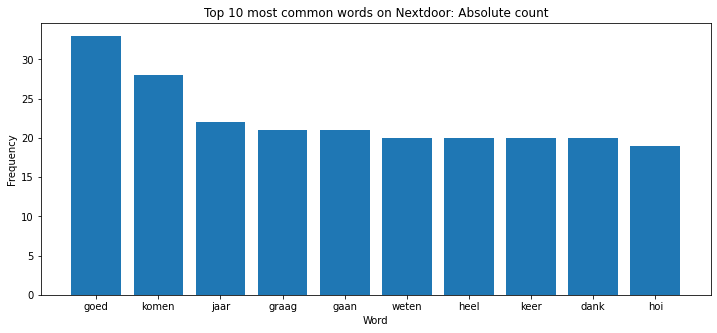

In [8]:
plt.figure(figsize=(12,5))
plt.title("Top 10 most common words on Nextdoor: Absolute count")
plt.ylabel("Frequency")
plt.xlabel("Word")
plt.bar(x = common_words.keys(), height = common_words.values())

<BarContainer object of 10 artists>

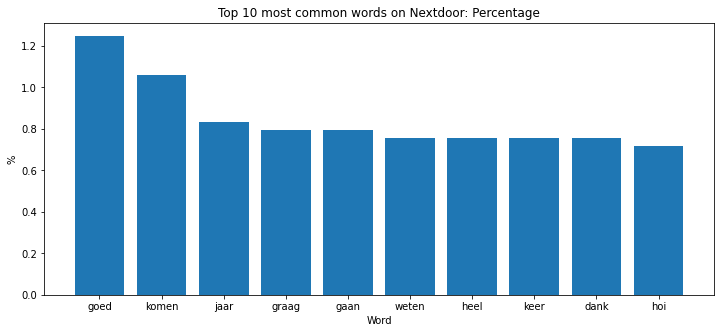

In [9]:
plt.figure(figsize=(12,5))
plt.title("Top 10 most common words on Nextdoor: Percentage")
plt.ylabel("%")
plt.xlabel("Word")
plt.bar(x = common_words_per.keys(), height = common_words_per.values())

### Wordcloud

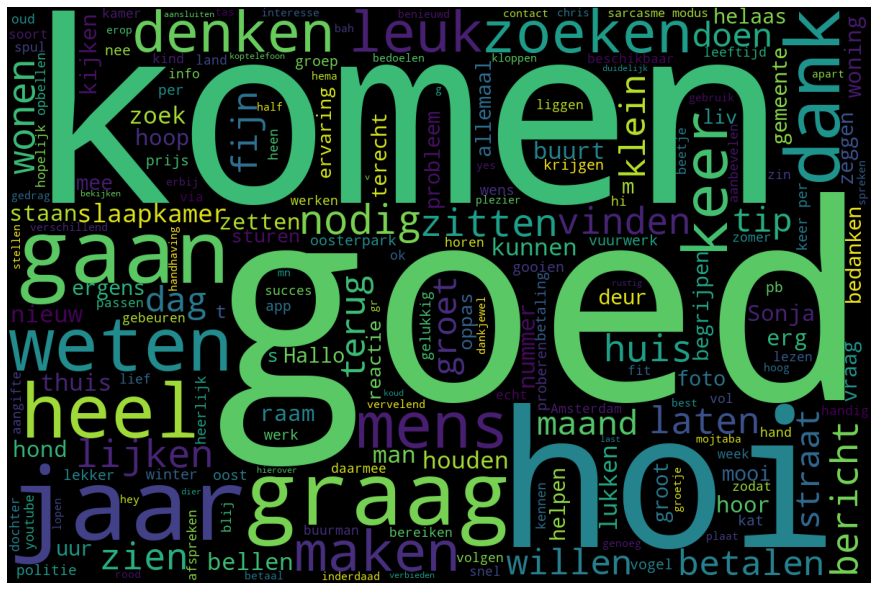

In [10]:
from wordcloud import WordCloud

joined_text = " ".join(df_nl["cleaned_comment"]) #creating document with all comments joined

wordcloud = WordCloud(width = 1200, height = 800,
                background_color ='black',
                min_font_size = 10).generate(joined_text)
 
# plot the WordCloud image                      
plt.figure(figsize = (12, 8), facecolor = None)
plt.imshow(wordcloud) #show the wordcloud
plt.axis("off") #turn off axes
plt.tight_layout(pad = 0)